In [1]:
#%matplotlib notebook

In [2]:
from cam import *
from pylab import *
from skimage import filters
from scipy.ndimage import gaussian_filter, laplace
%matplotlib inline

In [3]:
stack=loadstack('large_disk.zip')
t=stack.time()
dt=diff(t).mean()
obj=60
px2mu = 6.5/60

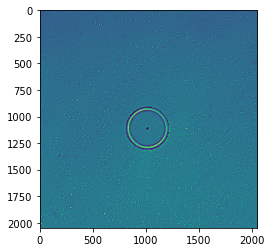

In [10]:
f=stack[1].data
figure(figsize=(4,4))
imshow(f)

## select kernel

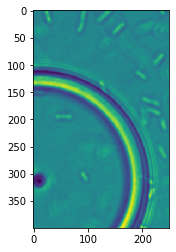

In [13]:
figure()
imshow(f[800:1200,1000:1250])

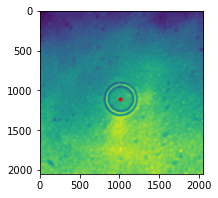

In [64]:
from scipy import ndimage as ndi
from skimage.feature import peak_local_max
from skimage import img_as_float


f=stack[0].data
fg= gaussian_filter(f,15)
#im = img_as_float()
im= fg.copy()

# image_max is the dilation of im with a 20*20 structuring element
# It is used within peak_local_max function
#image_max = ndi.maximum_filter(im, size=50, mode='constant')

# Comparison between image_max and im to find the coordinates of local maxima
coordinates = peak_local_max(-f, min_distance=700)

figure(figsize=(3,3))
imshow(fg)
plot(coordinates[:, 1], coordinates[:, 0], 'r.')
#figure(figsize=(10,10))
#imshow(image_max)


In [65]:
## tracking

N= len(stack)
max_Np =4
xc_temp=zeros([max_Np,N])
yc_temp=zeros([max_Np,N])
xc_temp[:]=NaN
yc_temp[:]=NaN
cc=0
for frame in stack:
    fg= gaussian_filter(frame.data,2)
#    xc[cc],yc[cc]=unravel_index(fg.argmax(), fg.shape)
    coordinates = peak_local_max(-fg, min_distance=700)
    # visit https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_peak_local_max.html#
    N_particles = len(coordinates[:,0])
    xc_temp[:N_particles,cc] = coordinates[:,1]
    yc_temp[:N_particles,cc] = coordinates[:,0]
    cc+=1


Text(0, 0.5, 'displacement [$\\mu$m]')

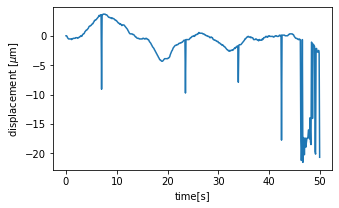

In [66]:
figure(figsize=(5,3))

y= (xc_temp[0,:]-xc_temp[0,0])*px2mu
t=arange(0,len(y))*dt
plot(t,y)
xlabel('time[s]')
ylabel('displacement [$\mu$m]')

In [68]:
### put the trajectory in the right place


xc=zeros([max_Np,N])
yc=zeros([max_Np,N])
xc[:]=NaN
yc[:]=NaN

xc[:,0]=xc_temp[:,0]
yc[:,0]=yc_temp[:,0]

for t in arange(0,N-1):
#    print(t)
    x1=xc[:,t].copy()
    y1=yc[:,t].copy()

    # arg of the not nan particles
    arg_good_particles = arange(len(y1))[~isnan(y1)]

    x2 = xc_temp[:,t+1].copy()
    y2 = yc_temp[:,t+1].copy()

    #remove nans
    x2=x2[~isnan(x2)]
    y2=y2[~isnan(y2)]
    x1=x1[~isnan(x1)]
    y1=y1[~isnan(y1)]


    dist_mat = (x1[:,newaxis] -x2[newaxis,:])**2 + (y1[:,newaxis] -y2[newaxis,:])**2 
    argmin_dist= nanargmin( dist_mat ,axis=1)
    
    # to fix
    # here i should add something that check for duplicates in argmin, if yes remove an element in xc[t+1]
    xc[arg_good_particles,t+1]= x2[argmin_dist ]
    yc[arg_good_particles,t+1]= y2[argmin_dist ]


In [69]:
## calculate msd
cut_N=400
xc[:,cut_N:]==nan
yc[:,cut_N:]==nan

msd= zeros([max_Np,N])
for t in arange(1,N):
    msd[:,t]= nanmean( ((xc[:,t:]-xc[:,:-t])**2+(yc[:,t:]-yc[:,:-t])**2),axis=1 )

/home/roberto/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  


Text(0, 0.5, 'msd [$\\mu$m$^{2}$]')

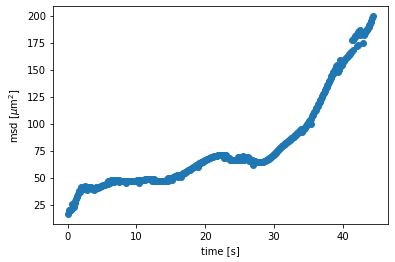

In [70]:
# normal disk
figure()
y= msd[0,1:int8(cut_N/2)]*(px2mu**2)
t=arange(1,len(y)+1)*dt
plot(t,y,'o')
xlabel('time [s]')
ylabel('msd [$\mu$m$^{2}$]')


In [ ]:
# normal dumbell
plot(msd[0,:])

In [71]:
dt

0.10007650701402807